# 06 — Topic Modeling with BERTopic

## Objectives
- Identify dominant discussion topics in e-wallet reviews
- Capture semantic patterns beyond word frequency
- Generate topic-based features for clustering

## Input
- data/processed/emotion_e_wallet_reviews.csv

## Output
- Topic labels
- Topic probability vectors
- Topic summary tables & visualizations


GOOGLE DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORT LIBRARIES

In [3]:
# Install core libraries
!pip install -U bertopic
!pip install -U sentence-transformers
!pip install -U umap-learn
!pip install -U hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


PATH CONFIGURATION & LOAD DATA

In [5]:
BASE_PATH = "/content/drive/MyDrive/ewallet_nlp_clustering_project"
PROCESSED_DATA_PATH = f"{BASE_PATH}/data/processed"
OUTPUT_PATH = f"{BASE_PATH}/outputs"

INPUT_FILE = f"{PROCESSED_DATA_PATH}/emotion_e_wallet_reviews.csv"

df = pd.read_csv(INPUT_FILE)
print(f"Dataset size: {df.shape}")

Dataset size: (11141, 22)


DATA SANITY CHECK

In [6]:
df[["app_name", "sentiment_label", "emotion_label", "clean_text"]].head()

,app_name,sentiment_label,emotion_label,clean_text
0,DANA,negative,neutral,woii dana kenapaa sihh haruss banget gitu kalo...
1,DANA,neutral,neutral,aplikasi buka
2,DANA,negative,neutral,tolong baik sistem aplikasi dana nya login pay...
3,DANA,positive,neutral,aplikasi bagus transaksi
4,DANA,neutral,neutral,blm buka dana cicik


## Why BERTopic?

BERTopic combines:
- Transformer embeddings (semantic understanding)
- UMAP (dimensionality reduction)
- HDBSCAN (density-based clustering)

Advantages:
- Works well on short texts (app reviews)
- Produces interpretable topics
- Generates topic probability distributions

This makes BERTopic ideal for downstream clustering.

LOAD SENTENCE EMBEDDING MODEL

In [7]:
embedding_model = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

INITIALIZE BERTopic MODEL

In [8]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True
)

INITIALIZE BERTopic MODEL

In [9]:
topics, topic_probs = topic_model.fit_transform(
    df["clean_text"].tolist()
)

df["topic_id"] = topics

2026-01-22 19:51:51,436 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/349 [00:00<?, ?it/s]

2026-01-22 19:51:57,627 - BERTopic - Embedding - Completed ✓
2026-01-22 19:51:57,629 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-22 19:52:29,416 - BERTopic - Dimensionality - Completed ✓
2026-01-22 19:52:29,418 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-22 19:52:46,269 - BERTopic - Cluster - Completed ✓
2026-01-22 19:52:46,282 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-22 19:52:46,592 - BERTopic - Representation - Completed ✓


BASIC TOPIC STATISTICS

In [10]:
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4255,-1_saldo_udah_driver_gak,"[saldo, udah, driver, gak, potong, dana, jam, ...",[pesan gofood masak suruh nunggu driver jam ke...
1,0,347,0_sya_rb_bayar_udh,"[sya, rb, bayar, udh, ovo, ilang, rp, admin, t...",[sya kecewa dgn apl sya pesan gokar ojek sya b...
2,1,303,1_upgrade_update_premier_premium,"[upgrade, update, premier, premium, gagal, mul...","[update aplikasi, update aplikasi, gak upgrade]"
3,2,214,2_aplikasi_uang_transaksi_hilang,"[aplikasi, uang, transaksi, hilang, duit, masu...",[aplikasi saldo hilang riwayat transaksi hati ...
4,3,182,3_kurang_gagal_transaksi_hilang,"[kurang, gagal, transaksi, hilang, saldo, riwa...","[gimana transaksi gagal saldo kurang, transaks..."
5,4,165,4_transfer_bank_rekening_gagal,"[transfer, bank, rekening, gagal, riwayat, mas...","[transfer bank gagal, transfer bank, transfer ..."
6,5,153,5_aplikasi_mantap_buka_bosok,"[aplikasi, mantap, buka, bosok, app, kompetito...","[mantap aplikasi nya, aplikasi nya mantap, apl..."
7,6,138,6_bagus_good_so_keren,"[bagus, good, so, keren, mantap, far, bagusmba...","[good good good, bagus bagus, good bagus]"
8,7,131,7_mudah_praktis_simpel_simple,"[mudah, praktis, simpel, simple, pergi, keren,...","[aplikasi mudah, aplikasi mudah, aplikasi muda..."
9,8,123,8_driver_drivernya_cancel_cari,"[driver, drivernya, cancel, cari, dpt, gofood,...",[aplikasi sen gofood slalu dapet driver parah ...


REMOVE NOISE ANALYSIS

In [11]:
noise_ratio = (df["topic_id"] == -1).mean()
print(f"Noise ratio: {noise_ratio:.2%}")

Noise ratio: 38.19%


TOP WORDS PER TOPIC

In [12]:
topic_model.get_topic(0)

[('sya', np.float64(0.009842601093157134)),
 ('rb', np.float64(0.008895905456274035)),
 ('bayar', np.float64(0.007901478552642682)),
 ('udh', np.float64(0.007814766863757169)),
 ('ovo', np.float64(0.007522900761380912)),
 ('ilang', np.float64(0.006849247064132423)),
 ('rp', np.float64(0.006564906103874275)),
 ('admin', np.float64(0.006521715123369802)),
 ('tolong', np.float64(0.00638919778604419)),
 ('dana', np.float64(0.006247473493055873))]

TOPIC VISUALIZATION (INTERACTIVE)

In [13]:
topic_model.visualize_topics()

TOPIC DISTRIBUTION BY APPLICATION

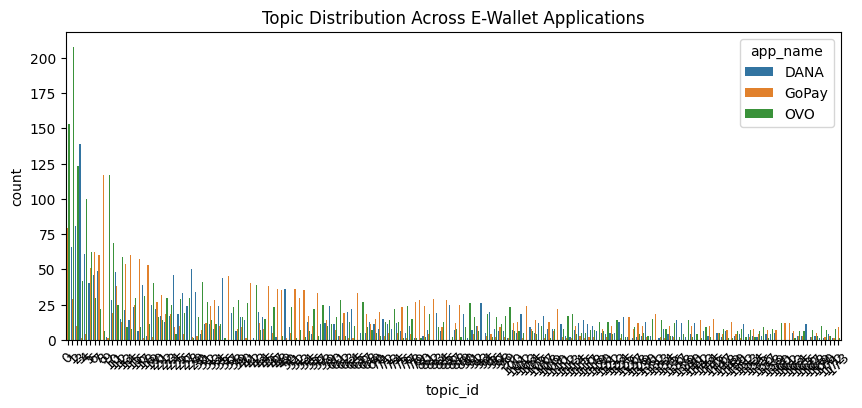

In [14]:
topic_app_dist = (
    df.groupby(["app_name", "topic_id"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(10,4))
sns.barplot(
    data=topic_app_dist[topic_app_dist["topic_id"] >= 0],
    x="topic_id",
    y="count",
    hue="app_name"
)
plt.title("Topic Distribution Across E-Wallet Applications")
plt.xticks(rotation=45)
plt.show()

TOPIC vs EMOTION ANALYSIS

In [15]:
pd.crosstab(
    df["topic_id"],
    df["emotion_label"],
    normalize="index"
).head(10)

emotion_label,anger,disgust,fear,joy,neutral,sadness,surprise
topic_id,,,,,,,
-1,0.001645,0.000940,0.004700,0.016921,0.961457,0.012456,0.00188
0,0.002882,0.000000,0.002882,0.020173,0.942363,0.031700,0.00000
1,0.000000,0.000000,0.006601,0.009901,0.980198,0.003300,0.00000
2,0.000000,0.000000,0.004673,0.004673,0.981308,0.009346,0.00000
3,0.000000,0.000000,0.000000,0.021978,0.978022,0.000000,0.00000
4,0.000000,0.006061,0.012121,0.000000,0.975758,0.006061,0.00000
5,0.000000,0.000000,0.000000,0.000000,0.993464,0.006536,0.00000
6,0.007246,0.000000,0.007246,0.086957,0.898551,0.000000,0.00000
7,0.000000,0.007634,0.000000,0.007634,0.977099,0.007634,0.00000


TOPIC PROBABILITY VECTORS

In [16]:
topic_prob_df = pd.DataFrame(
    topic_probs,
    columns=[f"topic_prob_{i}" for i in range(topic_probs.shape[1])]
)

df = pd.concat([df, topic_prob_df], axis=1)

SAVE DATASET WITH TOPIC FEATURES

In [17]:
OUTPUT_FILE = f"{PROCESSED_DATA_PATH}/topic_emotion_e_wallet_reviews.csv"

df.to_csv(OUTPUT_FILE, index=False)

print("Topic modeling dataset saved:")
print(OUTPUT_FILE)

Topic modeling dataset saved:
/content/drive/MyDrive/ewallet_nlp_clustering_project/data/processed/topic_emotion_e_wallet_reviews.csv


## Topic Modeling Summary

✔ BERTopic successfully extracted latent themes  
✔ Topic distributions differ across applications  
✔ Topics strongly correlate with specific emotions  
✔ Topic probability vectors prepared for clustering  

Conclusion:
Topic modeling provides semantic explanations behind user emotions
and enhances interpretability of user segmentation.
